Consider the function 

 $\min_{\mathbf{x}}{q(\mathbf{x})} = q(x_1,x_2) = 512(x_2 - x_1^2)^2 + (4 - x_1)^2$.

In [40]:
import numpy as np

In [41]:
def evalf(x):
  assert type(x) is np.ndarray
  assert len(x)==2
  return 512*(x[1]-x[0]**2)**2+(4-x[0])**2

In [42]:
def evalg(x):
  assert type(x) is np.ndarray
  assert len(x)==2
  return np.array([-2048*x[0]*(x[1]-x[0]**2)-2*(4-x[0]),1024*(x[1]-x[0]**2)])

In [43]:
def evalh(x):
  assert type(x) is np.ndarray 
  assert len(x)==2
  a11=6144*(x[0]**2)-2048*x[1]+2
  a12=-2048*x[0]
  a21=-2048*x[0]
  a22=1024
  return np.array([[a11,a12],[a21,a22]])

In [44]:
def find_condition_number(A):
  assert type(A) is np.ndarray
  assert A.shape[0]==2 and A.shape[1]==2
  eig_values=np.linalg.eigvals(A)
  return max(eig_values)/min(eig_values)

# **Exercise 2, Answer 1:**

The Hessian matrix for $q(x)$ is:-
$$\nabla^2q(x)=\begin{bmatrix}
6144x_1^2-2048x_2+2 & -2048x_1\\
-2048x_1 & 1024
\end{bmatrix}$$

The diagonal matrix $\mathbf{D}^k$ has the inverse of second partial derivative $\Big(\frac{\partial^2f(\mathbf{x_k})}{(\partial x_i)^2}\Big)^{-1}$ along the diagonal.


$\therefore \mathbf{D^k}$ can be written as:



$$ \mathbf{D^k} =
\begin{bmatrix}
  \frac{1}{ 6144x_1^2-2048x_2+2} & 0 \\ 0 & \frac{1}{1024}
\end{bmatrix}$$

In [45]:
def compute_D_k_diagonal(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  return np.array([[1/(6144*(x[0]**2)-2048*x[1]+2), 0], [0, 1/1024]])

In [46]:
compute_D_k_diagonal(np.array([1,1]))

array([[0.00024402, 0.        ],
       [0.        , 0.00097656]])

In [47]:
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  #Complete the code 
  alpha = alpha_start
  p=rho
  y=gamma
  #implement the backtracking line search
  while evalf(x+alpha*(-gradf)) > evalf(x)-y*alpha*np.dot((gradf.T),gradf):
    alpha=p*alpha


  #print('final step length:',alpha)
  return alpha

In [48]:
def compute_steplength_backtracking_scaled_direction(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = compute_D_k_diagonal(x)
  r=rho
  y=gamma
  while evalf(x + alpha*np.matmul(D_k,p)) > evalf(x) + y*alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha=alpha*r
  return alpha

  

In [49]:
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [50]:
def find_minimizer_gd(start_x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  cond_num_lst = []
  itr_lst = []

  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)

  k = 0
  #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
  
    if line_search_type == EXACT_LINE_SEARCH:
      step_length = compute_steplength_exact(g_x, A) #call the new function you wrote to compute the steplength
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking(x,g_x, alpha_start,rho, gamma) #call the new function you wrote to compute the steplength
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
      step_length = 0.1
    else:  
      raise ValueError('Line search type unknown. Please check!')

    cond_num_lst.append(find_condition_number(evalh(x)))
    #implement the gradient descent steps here   
    x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    itr_lst.append(k)

    #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
  return x ,k ,cond_num_lst, itr_lst

In [51]:
def find_minimizer_gdscaling(start_x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)

  k = 0
  while (np.linalg.norm(g_x) > tol):
    D_k = compute_D_k_diagonal(x) #continue as long as the norm of gradient is not close to zero upto a tolerance tol
  
    if line_search_type == EXACT_LINE_SEARCH:
      step_length = compute_steplength_exact(g_x, A) #call the new function you wrote to compute the steplength
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x, g_x, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
      step_length = 0.1
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
  return x, k

In [52]:
my_start_x=np.array([8.,8.])
my_tol=1e-5
print(f"For Backtracking line search procedure:")
x_opt_bls,iterations,c_list,itr_list = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, 1., 0.5,0.5)
print(f"Value of optimizer for Backtracking line search ={x_opt_bls} \nMinimum value is= {evalf(x_opt_bls)}\nNumber of iterations are= {iterations}")

For Backtracking line search procedure:
Params for Backtracking LS: alpha start: 1.0 rho: 0.5  gamma: 0.5
Value of optimizer for Backtracking line search =[ 3.9999598  15.99967843] 
Minimum value is= 1.615724753450513e-09
Number of iterations are= 902336


In [60]:
my_start_x=np.array([8.,8.])
my_tol=1e-5
print(f"For scaled Backtracking line search procedure:")
x_opt_bls,iterations = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, 1., 0.5,0.5)
print(f"Value of optimizer for scaled Backtracking line search ={x_opt_bls} \nMinimum value is= {evalf(x_opt_bls)}\nNumber of iterations are= {iterations}")

For scaled Backtracking line search procedure:
Value of optimizer for scaled Backtracking line search =[ 4.00000993 16.0000794 ] 
Minimum value is= 9.850897480037126e-11
Number of iterations are= 904703


# ***Exercise 2,Answer 3:***

Yes, I can identify and write the matrix Q whose condition number needs to be analyzed in the
new gradient descent scheme with scaling  $\mathbf{D}^k = (\nabla^2q(\mathbf{x}))^{-1} $
and Q  written as
$$\mathbf{Q} = \mathbf{(D^k)}^{\frac{1}{2}}H^k \mathbf{(D^k)}^{\frac{1}{2}}$$ where $H^k$ is Hessian matrix of a function for $k^{th}$ iteration

In [61]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  if np.linalg.det(evalh(x)) == 0:
    raise ValueError('Determinant of Hassian is zero')
  return np.linalg.inv(evalh(x))

In [62]:
def compute_steplength_backtracking_scaled_direction_newton(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  #assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = compute_D_k(x)
  y=gamma
  #implement the backtracking line search
  #print(evalf(x + alpha*p), evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(p), p) ))
  while evalf(x + alpha*np.matmul(D_k,p)) > evalf(x) + y * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha  

In [63]:
def find_minimizer_gdscaling_newton(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  condition_number_array_scaling = []
  list_of_iterations=[]
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)

  k = 0
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    D_k = compute_D_k(x)
    import scipy
    from scipy.linalg import sqrtm
    d = scipy.linalg.sqrtm(D_k)
    C1 = np.matmul(np.matmul(d,evalh(x)),d)
    condition_number_array_scaling.append(find_condition_number(C1))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction_newton(x, g_x, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    list_of_iterations.append(k)
  return x, k, condition_number_array_scaling,list_of_iterations

In [64]:
my_start_x = np.array([8.0,8.0])
my_tol= 1e-5
print(f"For scaled(newton's method) Backtracking line search procedure:")
x_opt_bls,iterations,condition_number_value, itr_lst2 = find_minimizer_gdscaling_newton(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, 1., 0.5,0.5)
print(f"Value of optimizer for scaled(newton's method) Backtracking line search ={x_opt_bls} \nMinimum value is= {evalf(x_opt_bls)}\nNumber of iterations are= {iterations}")

For scaled(newton's method) Backtracking line search procedure:
Value of optimizer for scaled(newton's method) Backtracking line search =[ 4. 16.] 
Minimum value is= 2.373469471365615e-25
Number of iterations are= 48


# ***Exercise 2,Answer 4:***

$\text{1. Backtracking line search (without scaling)}$

Value of optimizer=$[ 3.99995978,15.99967826] $

no. of iterations=902339

optimum value =$1.6173741774296086e-09$

$\text{2. Backtracking line search (with scaling)}$

value of optimizer=$[ 4.00000993,16.0000794 ]  $

no. of iterations=904703

optimum value =$9.850897480037126e-11$

$\text{3. Backtracking line search (with scaling)(newton's method)}$

value of optimizer=$[ 4.,16. ]  $

no. of iterations=48

optimum value =$2.356430075812841e-25$

Here I observed that we got exact value of optimizer by Backtracking line search (with scaling) by newton's method algorithm and this algorithm takes only 48 iterations to terminate while other iterations like Backtracking line search (with scaling) take 904703 iterations and Backtracking line search (without scaling) takes 902339 iterations to terminate.
And in all three algorithms the minimum value of function is approximately zero.

I plotted both graphs separately because it was hard to visualise these two graph in a single plot.

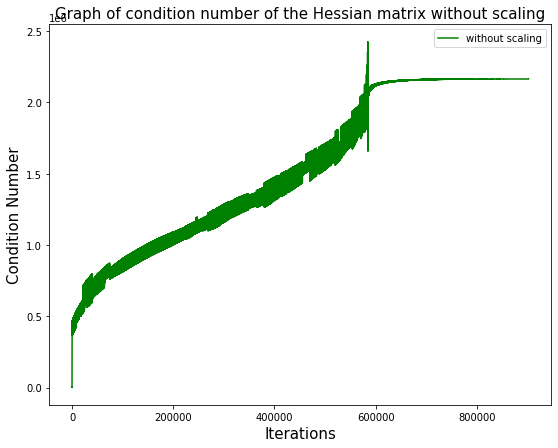

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,7))
plt.plot(itr_list,c_list,label= 'without scaling', color = 'green') 
plt.title('Graph of condition number of the Hessian matrix without scaling',fontsize=15)
plt.xlabel('Iterations',fontsize=15)
plt.ylabel('Condition Number',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

In [66]:
plt.figure(figsize=(9,7))
plt.plot(itr_lst2,condition_number_value,label='with scaling', color = 'orange')
plt.title('Graph of condition number of the Hessian matrix with scaling',fontsize=15)
plt.xlabel('Iterations',fontsize=15)
plt.ylabel('Condition Number',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()


In the above plot, I observe that the value of condition number increases from 0 to almost 2 in 600000 iterations in the case of without scaling graph, after this value of condition number becomes constant while in with scaling graph the value of condition number sharply increases and decreases from 0 to 5 iteration (approx) after that condition number lies in the nbd of 0 .